In [1]:
!pip install wandb --upgrade

In [2]:
import sys

IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")

sys.path.append("/kaggle/input/microstructure-reconstruction")
sys.path.append("/home/matias/microstructure-reconstruction")
sys.path.append("/content/gdrive/MyDrive/microstructure-reconstruction")

from imp import reload
from pathlib import Path
from pprint import pprint
from typing import Callable, List, Optional, Union
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
import numpy as numpy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.io import read_image
import torchvision.models as models
from tqdm import tqdm
from copy import deepcopy
import tools
import wandb
from time import time
from custom_datasets.dataset import SinglePhotoDataset, NChannelPhotosDataset

repo_path = tools.wandb_login()

seed = 42

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
print(f"[INFO]: Computation device: {device}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[INFO]: Computation device: cpu


In [3]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="Naive Network",
    job_type="test",
)

In [4]:
config = wandb.config
config.train_val_split = 0.7
config.seed = 42
config.batch_size = 32
config.learning_rate = 0.01
config.device = device
config.momentum = 0.9
config.architecture = "VGG"
config.input_width = 224
config.weight_decay = 0.0005
config.epochs = 100
config.frac_sample = 1
config.total_layers = 24
config.fixed_layers = 0
torch.manual_seed(config.seed)


In [5]:
topLevelFolder = repo_path / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics = topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"


In [6]:
data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = tools.convert_table_to_dataframe(data_at.get("fabrics"))
fabrics_df = fabrics_df.sample(frac=config.frac_sample, random_state=config.seed)
fabrics_df["photos"] = fabrics_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
single_entry_df = tools.convert_into_single_entry_df(fabrics_df)

train_df, test_df = train_test_split(
    fabrics_df,
    train_size=config.train_val_split,
    random_state=config.seed,
    shuffle=True,
)
transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config.input_width, config.input_width)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)
train_dataset = NChannelPhotosDataset(
    train_df, nb_photos_per_plane=1, normalization=True, transform=transform
)
validation_dataset = NChannelPhotosDataset(
    test_df,
    nb_photos_per_plane=1,
    normalization=[train_dataset.min, train_dataset.max],
    transform=transform,
)

In [7]:
class PreTrainedVGG(nn.Module):
    def __init__(self, input_width, output_size, total_layers=16, fixed_layers=4):
        super(PreTrainedVGG, self).__init__()
        assert total_layers >= fixed_layers
        vgg = models.vgg16_bn(pretrained=True)
        self.layers = nn.Sequential(*(list(vgg.features.children())[:total_layers]))
        for idx, child in enumerate(self.layers.children()):
            if idx < fixed_layers:
                for param in child.parameters():
                    param.requires_grad = False
            # else:
            #     reset_parameters = getattr(child, "reset_parameters", None)
            #     if callable(reset_parameters):
            #         child.reset_parameters()
        nb_channels, width, _ = (
            self.layers(torch.rand((1, 3, input_width, input_width))).squeeze().shape
        )
        # self.layers.add_module(
        #     str(total_layers), nn.MaxPool2d(kernel_size=width, stride=1)
        # )
        # self.layers.add_module(str(total_layers + 1), nn.Flatten())
        input_fc = int(width ** 2 * nb_channels)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Dropout2d(0.5),
            nn.Linear(in_features=input_fc, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            # nn.Dropout2d(0.5),
            # nn.Linear(in_features=2048, out_features=4096),
            # nn.ReLU(),
            # nn.Linear(in_features=4096, out_features=4096),
            # nn.ReLU(),
            # # nn.Dropout2d(0.5),
            # nn.Linear(in_features=2048, out_features=2048),
            # nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=output_size),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = PreTrainedVGG(
    input_width=config.input_width, output_size=23, total_layers=config.total_layers, fixed_layers=config.fixed_layers
).to(device)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")


[INFO]: 104,773,207 trainable parameters.


In [8]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, **kwargs
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=config.batch_size,
    shuffle=False,
)
loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

config.model_type = type(model)
config.loss_type = type(loss)
config.optimizer_type = type(optimizer)


torch.Size([23])


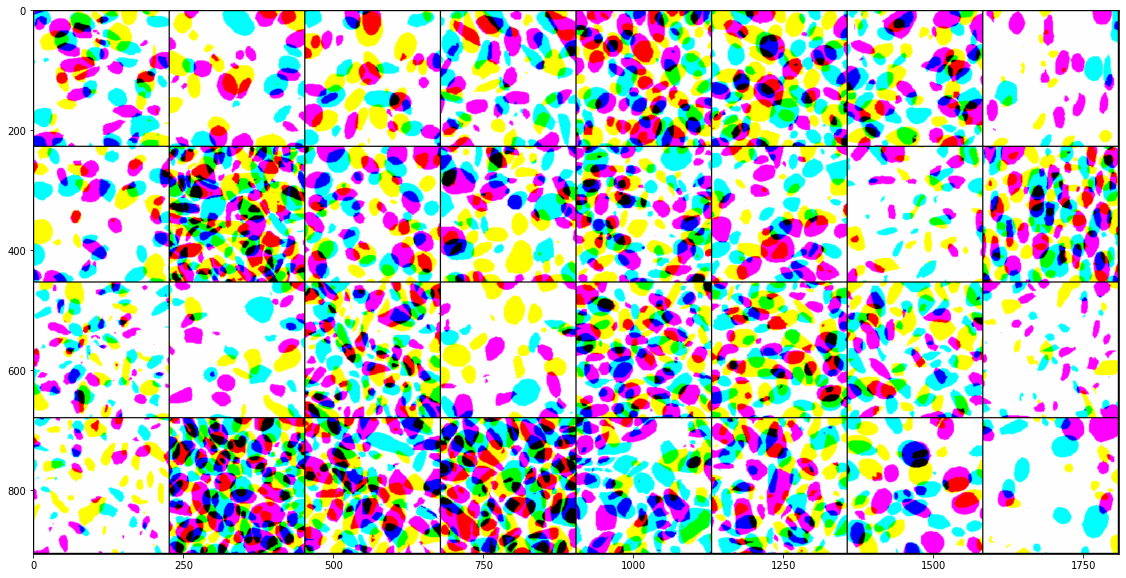

In [9]:
first_batch = next(iter(train_dataloader))
images = first_batch[0]
labels = first_batch[1]
print(labels[0].shape)

labels = first_batch[1]
grid = utils.make_grid(images)

fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [10]:
train_loss, val_loss, max_error = [], [], []
nb_epochs = deepcopy(config.epochs)
config.epochs = 0
for epoch in range(config.epochs, nb_epochs):
    current_train_loss = tools.train(model, device, train_dataloader, optimizer, loss)
    current_val_loss, _, current_max_error = tools.validate(
        model,
        device,
        validation_dataloader,
        loss,
        validation_dataset.min,
        validation_dataset.max,
    )

    train_loss.append(current_train_loss)
    val_loss.append(current_val_loss)
    max_error.append(current_max_error)
    print(
        "{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}".format(
            "Epoch", 
            epoch,
            "train loss",
            current_train_loss,
            "val loss",
            current_val_loss,
            "max error",
            current_max_error,
        )
    )
    if epoch >= 1:
        wandb.log(
            {
                "train_loss": current_train_loss,
                "val_loss": current_val_loss,
                "max_error": current_max_error,
                "epoch": epoch,
            }
        )
        config.epochs = epoch

100%|██████████| 14/14 [06:26<00:00, 27.63s/it]


Epoch        0                             
train loss   1268.1630503088236            
val loss     1.2877333462238312            
max error    1018.831298828125             


100%|██████████| 14/14 [06:25<00:00, 27.55s/it]


Epoch        1                             
train loss   2.87776380777359              
val loss     1.0541647970676422            
max error    2052.414794921875             


 14%|█▍        | 2/14 [01:26<08:40, 43.38s/it]


KeyboardInterrupt: ignored

In [ ]:
df = (fabrics_df.iloc[:, 1:-1] - fabrics_df.iloc[:, 1:-1].min()) / (fabrics_df.iloc[:, 1:-1].max() - fabrics_df.iloc[:, 1:-1].min())
df.mean().mean()

In [ ]:
outputs, targets = tools.compute_outputs(model, device, validation_dataloader)
errors = tools.compute_errors(outputs, targets, device, validation_dataset.min, validation_dataset.max)
errors_df = pd.DataFrame(errors.cpu().numpy(), columns=test_df.columns[1:-1])

In [ ]:
errors_df.max()*100

In [ ]:
# tools.add_pickle_object(run, tools.get_class_code(type(model)), "model_script")
import pickle
obj = tools.get_class_code(type(model))
filename = Path(run.dir) / "model_script.pkl"
with open(filename, "wb") as file:
    pickle.dump(obj, file)
run.finish()